# Recommendation Systems with TensorFlow

We'll be using matrix factorization to learn user and movie embeddings.



# Introduction

We will create a movie recommendation system based on the [MovieLens](https://movielens.org/) dataset available [here](http://grouplens.org/datasets/movielens/).  The data consists of movies ratings (on a scale of 1 to 5).

## Outline
  1. Exploring the MovieLens Data
  1. Preliminaries
  1. Training a matrix factorization model
  1. Inspecting the Embeddings
  1. Regularization in matrix factorization
  1. Softmax model training

## Setup

Let's get started by importing the required packages.

In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

# Install Altair and activate its colab renderer.
print("Installing Altair...")
!pip install git+git://github.com/altair-viz/altair.git
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('colab')
print("Done installing Altair.")

# Install spreadsheets and import authentication module.
USER_RATINGS = False
!pip install --upgrade -q gspread
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials

Instructions for updating:
non-resource variables are not supported in the long term
Installing Altair...
  Cloning git://github.com/altair-viz/altair.git to /tmp/pip-req-build-p8rvw0wu
  Running command git clone -q git://github.com/altair-viz/altair.git /tmp/pip-req-build-p8rvw0wu
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for altair: filename=altair-4.2.0.dev0-cp36-none-any.whl size=729976 sha256=d3a8196e1dedf0f6ed6421e3cda4177a33119c134100b845408c5d806a28e9d2
  Stored in directory: /tmp/pip-ephem-wheel-cache-xd_m1bng/wheels/01/fd/91/025b6149b3949af76e93b3b3ceca5bf12cbdebc98fa46f9ec6
Successfully built altair
  Found existing installation: altair 4.1.0
    Uninstalling altair-4.1.0:
      Successfully uninstalled altair-4.1.0
Done installing Altair.


We then download the MovieLens Data, and create DataFrames containing movies, users, and ratings.

In [2]:
# Download MovieLens data.
print("Downloading movielens data...")
from urllib.request import urlretrieve
import zipfile

urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info'))

# Load each data set (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    'ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

# Since the ids start at 1, we shift them to start at 0.
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

# Compute the number of movies to which a genre is assigned.
genre_occurences = movies[genre_cols].sum().to_dict()

# Since some movies can belong to more than one genre, we create different
# 'genre' columns as follows:
# - all_genres: all the active genres of the movie.
# - genre: randomly sampled from the active genres.
def mark_genres(movies, genres):
  def get_random_genre(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return np.random.choice(active)
  def get_all_genres(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return '-'.join(active)
  movies['genre'] = [
      get_random_genre(gs) for gs in zip(*[movies[genre] for genre in genres])]
  movies['all_genres'] = [
      get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

mark_genres(movies, genre_cols)

# Create one merged DataFrame containing all the movielens data.
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'


# I. Exploring the Movielens Data


### Users
Numeric user features.

In [3]:
users.describe()

age
count 943.000
mean   34.052
std    12.193
min     7.000
25%    25.000
50%    31.000
75%    43.000
max    73.000

Categorical user features

In [4]:
users.describe(include=[np.object])

user_id  sex occupation zip_code
count      943  943        943      943
unique     943    2         21      795
top        113    M    student    55414
freq         1  670        196        9

Create histograms to further understand the distribution of the users. We use Altair to create an interactive chart.

In [5]:
# The following functions are used to generate interactive Altair charts.
# We will display histograms of the data, sliced by a given attribute.

# Create filters to be used to slice the data.
occupation_filter = alt.selection_multi(fields=["occupation"])
occupation_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y("occupation:N"),
    color=alt.condition(
        occupation_filter,
        alt.Color("occupation:N", scale=alt.Scale(scheme='category20')),
        alt.value("lightgray")),
).properties(width=300, height=300, selection=occupation_filter)

# A function that generates a histogram of filtered data.
def filtered_hist(field, label, filter):
  """Creates a layered chart of histograms.
  The first layer (light gray) contains the histogram of the full data, and the
  second contains the histogram of the filtered data.
  Args:
    field: the field for which to generate the histogram.
    label: String label of the histogram.
    filter: an alt.Selection object to be used to filter the data.
  """
  base = alt.Chart().mark_bar().encode(
      x=alt.X(field, bin=alt.Bin(maxbins=10), title=label),
      y="count()",
  ).properties(
      width=300,
  )
  return alt.layer(
      base.transform_filter(filter),
      base.encode(color=alt.value('lightgray'), opacity=alt.value(.7)),
  ).resolve_scale(y='independent')


In [6]:
users_ratings = (
    ratings
    .groupby('user_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols()
    .merge(users, on='user_id')
)

# Create a chart for the count, and one for the mean.
alt.hconcat(
    filtered_hist('rating count', '# ratings / user', occupation_filter),
    filtered_hist('rating mean', 'mean user rating', occupation_filter),
    occupation_chart,
    data=users_ratings)

alt.HConcatChart(...)

### Movies

Looking at information about the movies and their ratings.

In [7]:
movies_ratings = movies.merge(
    ratings
    .groupby('movie_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols(),
    on='movie_id')

genre_filter = alt.selection_multi(fields=['genre'])
genre_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('genre'),
    color=alt.condition(
        genre_filter,
        alt.Color("genre:N"),
        alt.value('lightgray'))
).properties(height=300, selection=genre_filter)

In [8]:
(movies_ratings[['title', 'rating count', 'rating mean']]
 .sort_values('rating count', ascending=False)
 .head(10))

title  rating count  rating mean
49                Star Wars (1977)           583        4.358
257                 Contact (1997)           509        3.804
99                    Fargo (1996)           508        4.156
180      Return of the Jedi (1983)           507        4.008
293               Liar Liar (1997)           485        3.157
285    English Patient, The (1996)           481        3.657
287                  Scream (1996)           478        3.441
0                 Toy Story (1995)           452        3.878
299           Air Force One (1997)           431        3.631
120  Independence Day (ID4) (1996)           429        3.438

In [9]:
(movies_ratings[['title', 'rating count', 'rating mean']]
 .mask('rating count', lambda x: x > 20)
 .sort_values('rating mean', ascending=False)
 .head(10))

title  ...  rating mean
407                              Close Shave, A (1995)  ...        4.491
317                            Schindler's List (1993)  ...        4.466
168                         Wrong Trousers, The (1993)  ...        4.466
482                                  Casablanca (1942)  ...        4.457
113  Wallace & Gromit: The Best of Aardman Animatio...  ...        4.448
63                    Shawshank Redemption, The (1994)  ...        4.445
602                                 Rear Window (1954)  ...        4.388
11                          Usual Suspects, The (1995)  ...        4.386
49                                    Star Wars (1977)  ...        4.358
177                                12 Angry Men (1957)  ...        4.344

[10 rows x 3 columns]

Finally, the last chart shows the distribution of the number of ratings and average rating.

In [10]:
# Display the number of ratings and average rating per movie.
alt.hconcat(
    filtered_hist('rating count', '# ratings / movie', genre_filter),
    filtered_hist('rating mean', 'mean movie rating', genre_filter),
    genre_chart,
    data=movies_ratings)

alt.HConcatChart(...)

#II. Preliminaries
### Build a tf.SparseTensor representation of the Rating Matrix.

In [11]:
def build_rating_sparse_tensor(ratings_df):
  """
  Args:
    ratings_df: a pd.DataFrame with `user_id`, `movie_id` and `rating` columns.
  Returns:
    A tf.SparseTensor representing the ratings matrix.
  """
  # ========================= Complete this section ============================
  indices = ratings_df[['user_id', 'movie_id']].values
  values = ratings_df['rating'].values
  # ============================================================================

  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[users.shape[0], movies.shape[0]])

In [12]:
#@title Solution
def build_rating_sparse_tensor(ratings_df):
  """
  Args:
    ratings_df: a pd.DataFrame with `user_id`, `movie_id` and `rating` columns.
  Returns:
    a tf.SparseTensor representing the ratings matrix.
  """
  indices = ratings_df[['user_id', 'movie_id']].values
  values = ratings_df['rating'].values
  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[users.shape[0], movies.shape[0]])

### Mean Squared Error

In [13]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
  """
  Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    movie_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of movie j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  # ========================= Complete this section ============================
  predictions = tf.gather_nd(
      tf.matmul(user_embeddings, movie_embeddings, transpose_b=True),
      sparse_ratings.indices)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  # ============================================================================
  return loss

In [14]:
#@title Alternate Solution
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
  """
  Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    movie_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of movie j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  predictions = tf.reduce_sum(
      tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) *
      tf.gather(movie_embeddings, sparse_ratings.indices[:, 1]),
      axis=1)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

# III. Training a Matrix Factorization model

## CFModel (Collaborative Filtering Model) helper class
This is a simple class to train a matrix factorization model using stochastic gradient descent.

The class constructor takes
- the user embeddings U (a `tf.Variable`).
- the movie embeddings V, (a `tf.Variable`).
- a loss to optimize (a `tf.Tensor`).
- an optional list of metrics dictionaries, each mapping a string (the name of the metric) to a tensor. These are evaluated and plotted during training (e.g. training error and test error).

After training, one can access the trained embeddings using the `model.embeddings` dictionary.


In [15]:
class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

### Build a Matrix Factorization model and train it

Using `sparse_mean_square_error` function, this function builds a `CFModel` by creating the embedding variables and the train and test losses.

In [16]:
def build_model(ratings, embedding_dim=3, init_stddev=1.):
  """
  Args:
    ratings: a DataFrame of the ratings
    embedding_dim: the dimension of the embedding vectors.
    init_stddev: float, the standard deviation of the random initial embeddings.
  Returns:
    model: a CFModel.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  # ========================= Complete this section ============================
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  # ============================================================================
  # Initialize the embeddings using a normal distribution.
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  # ========================= Complete this section ============================
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)
  # ============================================================================
  metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
  embeddings = {
      "user_id": U,
      "movie_id": V
  }
  return CFModel(embeddings, train_loss, [metrics])

It's time to train the model!

 iteration 1000: train_error=0.376295, test_error=1.379486

[{'test_error': 1.3794861, 'train_error': 0.37629488}]

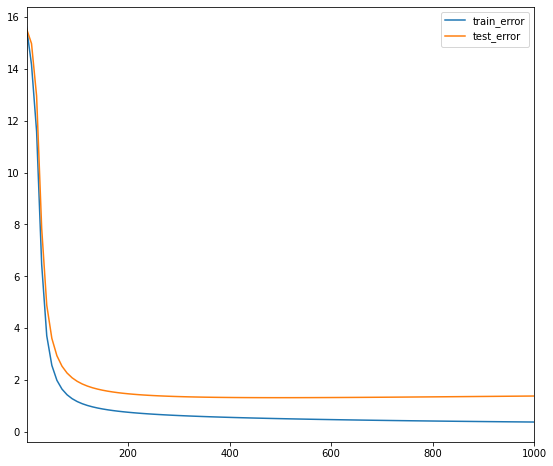

In [17]:
# Build the CF model and train it.
model = build_model(ratings, embedding_dim=30, init_stddev=0.5)
model.train(num_iterations=1000, learning_rate=10.)

# IV. Inspecting the Embeddings

In this section, we take a closer look at the learned embeddings, by
- computing the recommendations
- looking at the nearest neighbors of some movies,
- looking at the norms of the movie embeddings,
- visualizing the embedding in a projected embedding space.

### Function that computes the scores of the candidates
We start by writing a function that, given a query embedding $u \in \mathbb R^d$ and item embeddings $V \in \mathbb R^{N \times d}$, computes the item scores.
There are different similarity measures we can use, and these can yield different results. We will compare the following:
- dot product
- cosine

In [18]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  # ========================= Complete this section ============================
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  # ============================================================================
  return scores

Equipped with this function, we can compute recommendations, where the query embedding can be either a user embedding or a movie embedding.

In [19]:
# User recommendations and nearest neighbors (run this cell)
def user_recommendations(model, measure=DOT, exclude_rated=False, k=6):
  if USER_RATINGS:
    scores = compute_scores(
        model.embeddings["user_id"][943], model.embeddings["movie_id"], measure)
    score_key = measure + ' score'
    df = pd.DataFrame({
        score_key: list(scores),
        'movie_id': movies['movie_id'],
        'titles': movies['title'],
        'genres': movies['all_genres'],
    })
    if exclude_rated:
      # remove movies that are already rated
      rated_movies = ratings[ratings.user_id == "943"]["movie_id"].values
      df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]
    display.display(df.sort_values([score_key], ascending=False).head(k))  

def movie_neighbors(model, title_substring, measure=DOT, k=6):
  # Search for movie ids that match the given substring.
  ids =  movies[movies['title'].str.contains(title_substring)].index.values
  titles = movies.iloc[ids]['title'].values
  if len(titles) == 0:
    raise ValueError("Found no movies with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching movie. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  movie_id = ids[0]
  scores = compute_scores(
      model.embeddings["movie_id"][movie_id], model.embeddings["movie_id"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'titles': movies['title'],
      'genres': movies['all_genres']
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))

### Your recommendations

If you chose to input your recommendations, you can run the next cell to generate recommendations for you.

In [20]:
user_recommendations(model, measure=COSINE, k=5)

How do the recommendations look?

### Movie Nearest neighbors

Let's look at the neareast neighbors for some of the movies.

In [21]:
movie_neighbors(model, "Aladdin", DOT)
movie_neighbors(model, "Aladdin", COSINE)

Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


dot score  ...                               genres
94       5.951  ...    Animation-Children-Comedy-Musical
63       5.651  ...                                Drama
317      5.543  ...                            Drama-War
21       5.501  ...                     Action-Drama-War
49       5.456  ...  Action-Adventure-Romance-Sci-Fi-War
793      5.429  ...                        Drama-Romance

[6 rows x 3 columns]

Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


cosine score  ...                             genres
94          1.000  ...  Animation-Children-Comedy-Musical
0           0.864  ...          Animation-Children-Comedy
63          0.843  ...                              Drama
209         0.837  ...                   Action-Adventure
470         0.828  ...                          Drama-War
203         0.828  ...                      Comedy-Sci-Fi

[6 rows x 3 columns]

It seems that the quality of learned embeddings may not be very good. This will be addressed in Section V by adding several regularization techniques. First, we will further inspect the embeddings.

## Movie Embedding Norm

We can also observe that the recommendations with dot-product and cosine are different: with dot-product, the model tends to recommend popular movies. This can be explained by the fact that in matrix factorization models, the norm of the embedding is often correlated with popularity (popular movies have a larger norm), which makes it more likely to recommend more popular items. We can confirm this hypothesis by sorting the movies by their embedding norm, as done in the next cell.

In [22]:
# Embedding Visualization code

def movie_embedding_norm(models):
  """Visualizes the norm and number of ratings of the movie embeddings.
  Args:
    model: A MFModel object.
  """
  if not isinstance(models, list):
    models = [models]
  df = pd.DataFrame({
      'title': movies['title'],
      'genre': movies['genre'],
      'num_ratings': movies_ratings['rating count'],
  })
  charts = []
  brush = alt.selection_interval()
  for i, model in enumerate(models):
    norm_key = 'norm'+str(i)
    df[norm_key] = np.linalg.norm(model.embeddings["movie_id"], axis=1)
    nearest = alt.selection(
        type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
        empty='none')
    base = alt.Chart().mark_circle().encode(
        x='num_ratings',
        y=norm_key,
        color=alt.condition(brush, alt.value('#4c78a8'), alt.value('lightgray'))
    ).properties(
        selection=nearest).add_selection(brush)
    text = alt.Chart().mark_text(align='center', dx=5, dy=-5).encode(
        x='num_ratings', y=norm_key,
        text=alt.condition(nearest, 'title', alt.value('')))
    charts.append(alt.layer(base, text))
  return alt.hconcat(*charts, data=df)

def visualize_movie_embeddings(data, x, y):
  nearest = alt.selection(
      type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
      empty='none')
  base = alt.Chart().mark_circle().encode(
      x=x,
      y=y,
      color=alt.condition(genre_filter, "genre", alt.value("whitesmoke")),
  ).properties(
      width=600,
      height=600,
      selection=nearest)
  text = alt.Chart().mark_text(align='left', dx=5, dy=-5).encode(
      x=x,
      y=y,
      text=alt.condition(nearest, 'title', alt.value('')))
  return alt.hconcat(alt.layer(base, text), genre_chart, data=data)

def tsne_movie_embeddings(model):
  """Visualizes the movie embeddings, projected using t-SNE with Cosine measure.
  Args:
    model: A MFModel object.
  """
  tsne = sklearn.manifold.TSNE(
      n_components=2, perplexity=40, metric='cosine', early_exaggeration=10.0,
      init='pca', verbose=True, n_iter=400)

  print('Running t-SNE...')
  V_proj = tsne.fit_transform(model.embeddings["movie_id"])
  movies.loc[:,'x'] = V_proj[:, 0]
  movies.loc[:,'y'] = V_proj[:, 1]
  return visualize_movie_embeddings(movies, 'x', 'y')

In [23]:
movie_embedding_norm(model)

alt.HConcatChart(...)

 iteration 1000: train_error=0.354977, test_error=0.966837Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


dot score  ...                                     genres
171      5.461  ...  Action-Adventure-Drama-Romance-Sci-Fi-War
49       5.431  ...        Action-Adventure-Romance-Sci-Fi-War
94       5.333  ...          Animation-Children-Comedy-Musical
180      5.312  ...        Action-Adventure-Romance-Sci-Fi-War
70       4.868  ...                 Animation-Children-Musical
63       4.780  ...                                      Drama

[6 rows x 3 columns]

Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


cosine score                  titles                             genres
94           1.000          Aladdin (1992)  Animation-Children-Comedy-Musical
70           0.873   Lion King, The (1994)         Animation-Children-Musical
1442         0.862        8 Seconds (1994)                              Drama
612          0.856   My Man Godfrey (1936)                             Comedy
1196         0.846  Family Thing, A (1996)                       Comedy-Drama
1449         0.839  Golden Earrings (1947)                  Adventure-Romance

alt.HConcatChart(...)

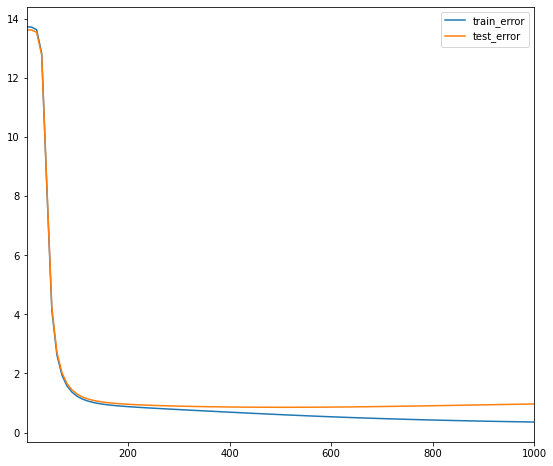

In [24]:
model_lowinit = build_model(ratings, embedding_dim=30, init_stddev=0.05)
model_lowinit.train(num_iterations=1000, learning_rate=10.)
movie_neighbors(model_lowinit, "Aladdin", DOT)
movie_neighbors(model_lowinit, "Aladdin", COSINE)
movie_embedding_norm([model, model_lowinit])

## Embedding visualization
Since it is hard to visualize embeddings in a higher-dimensional space (when the embedding dimension $k > 3$), one approach is to project the embeddings to a lower dimensional space. T-SNE (T-distributed Stochastic Neighbor Embedding) is an algorithm that projects the embeddings while attempting to preserve their pariwise distances.

In [25]:
tsne_movie_embeddings(model_lowinit)

Running t-SNE...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1682 samples in 0.001s...
[t-SNE] Computed neighbors for 1682 samples in 0.089s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1682
[t-SNE] Computed conditional probabilities for sample 1682 / 1682
[t-SNE] Mean sigma: 0.116806
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.985416
[t-SNE] KL divergence after 400 iterations: 2.215028


alt.HConcatChart(...)

We can observe that the embeddings do not seem to have any notable structure, and the embeddings of a given genre are located all over the embedding space. This confirms the poor quality of the learned embeddings. One of the main reasons is that we only trained the model on observed pairs, and without regularization.

# V. Regularization In Matrix Factorization

In the previous section, our loss was defined as the mean squared error on the observed part of the rating matrix.  As discussed in the lecture, this can be problematic as the model does not learn how to place the embeddings of irrelevant movies. This phenomenon is known as *folding*.

### Build a regularized Matrix Factorization model and train it


In [26]:
def gravity(U, V):
  """Creates a gravity loss given two embedding matrices."""
  return 1. / (U.shape[0].value*V.shape[0].value) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

def build_regularized_model(
    ratings, embedding_dim=3, regularization_coeff=.1, gravity_coeff=1.,
    init_stddev=0.1):
  """
  Args:
    ratings: the DataFrame of movie ratings.
    embedding_dim: The dimension of the embedding space.
    regularization_coeff: The regularization coefficient lambda.
    gravity_coeff: The gravity regularization coefficient lambda_g.
  Returns:
    A CFModel object that uses a regularized loss.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))

  # ========================= Complete this section ============================
  error_train = sparse_mean_square_error(A_train, U, V)
  error_test = sparse_mean_square_error(A_test, U, V)
  gravity_loss = gravity_coeff * gravity(U, V)
  regularization_loss = regularization_coeff * (
      tf.reduce_sum(U*U)/U.shape[0].value + tf.reduce_sum(V*V)/V.shape[0].value)
  
  # ============================================================================
  total_loss = error_train + regularization_loss + gravity_loss
  losses = {
      'train_error': error_train,
      'test_error': error_test,
  }
  loss_components = {
      'observed_loss': error_train,
      'regularization_loss': regularization_loss,
      'gravity_loss': gravity_loss,
  }
  embeddings = {"user_id": U, "movie_id": V}

  return CFModel(embeddings, total_loss, [losses, loss_components])

 iteration 2000: train_error=1.000045, test_error=2.401717, observed_loss=1.000045, regularization_loss=0.854156, gravity_loss=1.315997

[{'test_error': 2.4017167, 'train_error': 1.0000452},
 {'gravity_loss': 1.3159966,
  'observed_loss': 1.0000452,
  'regularization_loss': 0.8541565}]

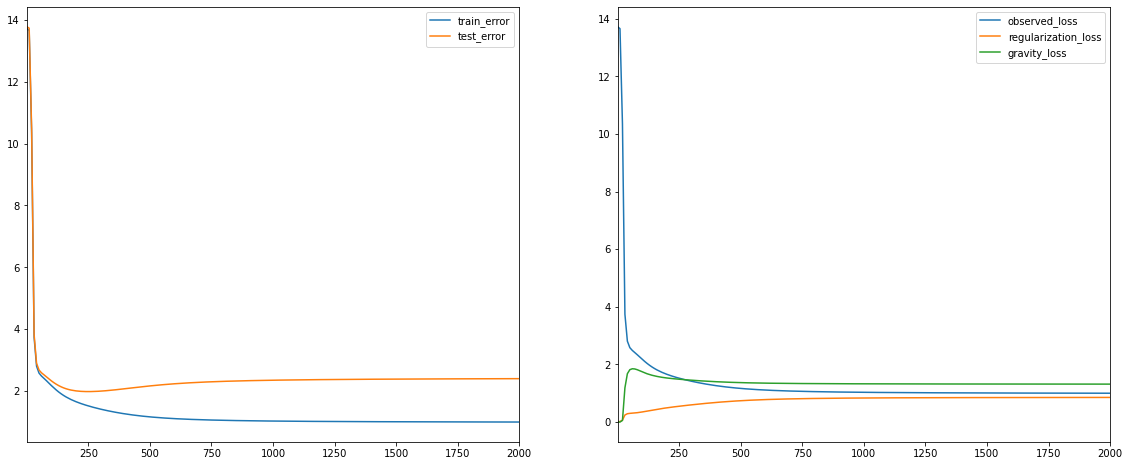

In [27]:
reg_model = build_regularized_model(
    ratings, regularization_coeff=0.1, gravity_coeff=1.0, embedding_dim=35,
    init_stddev=.05)
reg_model.train(num_iterations=2000, learning_rate=20.)

Adding the regularization terms results in a higher MSE, both on the training and test set. However, the quality of the recommendations improves. This highlights a tension between fitting the observed data and minimizing the regularization terms. Fitting the observed data often emphasizes learning high similarity (between items with many interactions), but a good embedding representation also requires learning low similarity (between items with few or no interactions).

### Inspect the results


In [28]:
user_recommendations(reg_model, DOT, exclude_rated=True, k=10)

In [29]:
movie_neighbors(reg_model, "Aladdin", DOT)
movie_neighbors(reg_model, "Aladdin", COSINE)

Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


dot score  ...                                     genres
94       9.195  ...          Animation-Children-Comedy-Musical
70       8.219  ...                 Animation-Children-Musical
587      7.919  ...                 Animation-Children-Musical
171      7.622  ...  Action-Adventure-Drama-Romance-Sci-Fi-War
173      7.457  ...                           Action-Adventure
172      7.357  ...            Action-Adventure-Comedy-Romance

[6 rows x 3 columns]

Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


cosine score  ...                             genres
94          1.000  ...  Animation-Children-Comedy-Musical
70          0.888  ...         Animation-Children-Musical
587         0.874  ...         Animation-Children-Musical
81          0.768  ...            Action-Adventure-Sci-Fi
417         0.752  ...         Animation-Children-Musical
72          0.738  ...              Action-Comedy-Western

[6 rows x 3 columns]

Here we compare the embedding norms for `model` and `reg_model`. Selecting a subset of the embeddings will highlight them on both charts simultaneously.

In [30]:
movie_embedding_norm([model, model_lowinit, reg_model])

alt.HConcatChart(...)

In [31]:
# Visualize the embeddings
tsne_movie_embeddings(reg_model)

Running t-SNE...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1682 samples in 0.000s...
[t-SNE] Computed neighbors for 1682 samples in 0.141s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1682
[t-SNE] Computed conditional probabilities for sample 1682 / 1682
[t-SNE] Mean sigma: 0.252526
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.280815
[t-SNE] KL divergence after 400 iterations: 1.500917


alt.HConcatChart(...)

We should observe that the embeddings have a lot more structure than the unregularized case. Try selecting different genres and observe how they tend to form clusters (for example Horror, Animation and Children).

### Conclusion
This concludes this section on matrix factorization models. Note that while the scale of the problem is small enough to allow efficient training using SGD, many practical problems need to be trained using more specialized algorithms such as Alternating Least Squares (see [tf.contrib.factorization.WALSMatrixFactorization](https://www.tensorflow.org/api_docs/python/tf/contrib/factorization/WALSMatrixFactorization) for a TF implementation).

# VI. Softmax model

In this section, we will train a simple softmax model that predicts whether a given user has rated a movie.

The model will take as input a feature vector $x$ representing the list of movies the user has rated. We start from the ratings DataFrame, which we group by user_id.

In [32]:
rated_movies = (ratings[["user_id", "movie_id"]]
                .groupby("user_id", as_index=False)
                .aggregate(lambda x: list(x)))
rated_movies.head()

user_id                                           movie_id
0       0  [60, 188, 32, 159, 19, 201, 170, 264, 154, 116...
1       1  [291, 250, 49, 313, 296, 289, 311, 280, 12, 27...
2      10  [110, 557, 731, 226, 424, 739, 722, 37, 724, 1...
3     100  [828, 303, 595, 221, 470, 404, 280, 251, 281, ...
4     101  [767, 822, 69, 514, 523, 321, 624, 160, 447, 4...

We then create a function that generates an example batch, such that each example contains the following features:
- movie_id: A tensor of strings of the movie ids that the user rated.
- genre: A tensor of strings of the genres of those movies
- year: A tensor of strings of the release year.

In [34]:
# Batch generation code
years_dict = {
    movie: year for movie, year in zip(movies["movie_id"], movies["year"])
}
genres_dict = {
    movie: genres.split('-')
    for movie, genres in zip(movies["movie_id"], movies["all_genres"])
}

def make_batch(ratings, batch_size):
  """Creates a batch of examples.
  Args:
    ratings: A DataFrame of ratings such that examples["movie_id"] is a list of
      movies rated by a user.
    batch_size: The batch size.
  """
  def pad(x, fill):
    return pd.DataFrame.from_dict(x).fillna(fill).values

  movie = []
  year = []
  genre = []
  label = []
  for movie_ids in ratings["movie_id"].values:
    movie.append(movie_ids)
    genre.append([x for movie_id in movie_ids for x in genres_dict[movie_id]])
    year.append([years_dict[movie_id] for movie_id in movie_ids])
    label.append([int(movie_id) for movie_id in movie_ids])
  features = {
      "movie_id": pad(movie, ""),
      "year": pad(year, ""),
      "genre": pad(genre, ""),
      "label": pad(label, -1)
  }
  batch = (
      tf.data.Dataset.from_tensor_slices(features)
      .shuffle(1000)
      .repeat()
      .batch(batch_size)
      .make_one_shot_iterator()
      .get_next())
  return batch

def select_random(x):
  """Selectes a random elements from each row of x."""
  def to_float(x):
    return tf.cast(x, tf.float32)
  def to_int(x):
    return tf.cast(x, tf.int64)
  batch_size = tf.shape(x)[0]
  rn = tf.range(batch_size)
  nnz = to_float(tf.count_nonzero(x >= 0, axis=1))
  rnd = tf.random_uniform([batch_size])
  ids = tf.stack([to_int(rn), to_int(nnz * rnd)], axis=1)
  return to_int(tf.gather_nd(x, ids))


### Loss function
Recall that the softmax model maps the input features $x$ to a user embedding $\psi(x) \in \mathbb R^d$, where $d$ is the embedding dimension. This vector is then multiplied by a movie embedding matrix $V \in \mathbb R^{m \times d}$ (where $m$ is the number of movies), and the final output of the model is the softmax of the product
$$
\hat p(x) = \text{softmax}(\psi(x) V^\top).
$$
Given a target label $y$, if we denote by $p = 1_y$ a one-hot encoding of this target label, then the loss is the cross-entropy between $\hat p(x)$ and $p$.

### Write a loss function for the softmax model.

We will write a function that takes tensors representing the user embeddings $\psi(x)$, movie embeddings $V$, target label $y$, and return the cross-entropy loss.


In [35]:
def softmax_loss(user_embeddings, movie_embeddings, labels):
  """Returns the cross-entropy loss of the softmax model.
  Args:
    user_embeddings: A tensor of shape [batch_size, embedding_dim].
    movie_embeddings: A tensor of shape [num_movies, embedding_dim].
    labels: A tensor of [batch_size], such that labels[i] is the target label
      for example i.
  Returns:
    The mean cross-entropy loss.
  """
  # Verify that the embddings have compatible dimensions
  user_emb_dim = user_embeddings.shape[1].value
  movie_emb_dim = movie_embeddings.shape[1].value
  if user_emb_dim != movie_emb_dim:
    raise ValueError(
        "The user embedding dimension %d should match the movie embedding "
        "dimension % d" % (user_emb_dim, movie_emb_dim))

  logits = tf.matmul(user_embeddings, movie_embeddings, transpose_b=True)
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
      logits=logits, labels=labels))
  return loss

### Build a softmax model, train it, and inspect its embeddings.

We are now ready to build a softmax CFModel. 
![Softmax model](https://github.com/google/eng-edu/blob/master/ml/recommendation-systems/images/softmax-model.png?raw=true)



In [36]:
def build_softmax_model(rated_movies, embedding_cols, hidden_dims):
  """Builds a Softmax model for MovieLens.
  Args:
    rated_movies: DataFrame of traing examples.
    embedding_cols: A dictionary mapping feature names (string) to embedding
      column objects. This will be used in tf.feature_column.input_layer() to
      create the input layer.
    hidden_dims: int list of the dimensions of the hidden layers.
  Returns:
    A CFModel object.
  """
  def create_network(features):
    """Maps input features dictionary to user embeddings.
    Args:
      features: A dictionary of input string tensors.
    Returns:
      outputs: A tensor of shape [batch_size, embedding_dim].
    """
    # Create a bag-of-words embedding for each sparse feature.
    inputs = tf.feature_column.input_layer(features, embedding_cols)
    # Hidden layers.
    input_dim = inputs.shape[1].value
    for i, output_dim in enumerate(hidden_dims):
      w = tf.get_variable(
          "hidden%d_w_" % i, shape=[input_dim, output_dim],
          initializer=tf.truncated_normal_initializer(
              stddev=1./np.sqrt(output_dim))) / 10.
      outputs = tf.matmul(inputs, w)
      input_dim = output_dim
      inputs = outputs
    return outputs

  train_rated_movies, test_rated_movies = split_dataframe(rated_movies)
  train_batch = make_batch(train_rated_movies, 200)
  test_batch = make_batch(test_rated_movies, 100)

  with tf.variable_scope("model", reuse=False):
    # Train
    train_user_embeddings = create_network(train_batch)
    train_labels = select_random(train_batch["label"])
  with tf.variable_scope("model", reuse=True):
    # Test
    test_user_embeddings = create_network(test_batch)
    test_labels = select_random(test_batch["label"])
    movie_embeddings = tf.get_variable(
        "input_layer/movie_id_embedding/embedding_weights")

  test_loss = softmax_loss(
      test_user_embeddings, movie_embeddings, test_labels)
  train_loss = softmax_loss(
      train_user_embeddings, movie_embeddings, train_labels)
  _, test_precision_at_10 = tf.metrics.precision_at_k(
      labels=test_labels,
      predictions=tf.matmul(test_user_embeddings, movie_embeddings, transpose_b=True),
      k=10)

  metrics = (
      {"train_loss": train_loss, "test_loss": test_loss},
      {"test_precision_at_10": test_precision_at_10}
  )
  embeddings = {"movie_id": movie_embeddings}
  return CFModel(embeddings, train_loss, metrics)

### Train the Softmax model

We are now ready to train the softmax model. You can set the following hyperparameters:
- learning rate
- number of iterations. Note: you can run `softmax_model.train()` again to continue training the model from its current state.
- input embedding dimensions (the `input_dims` argument)
- number of hidden layers and size of each layer (the `hidden_dims` argument)

Note: since our input features are string-valued (movie_id, genre, and year), we need to map them to integer ids. 

 iteration 3000: train_loss=5.690237, test_loss=5.566818, test_precision_at_10=0.011308

({'test_loss': 5.5668178, 'train_loss': 5.690237},
 {'test_precision_at_10': 0.011307564145284905})

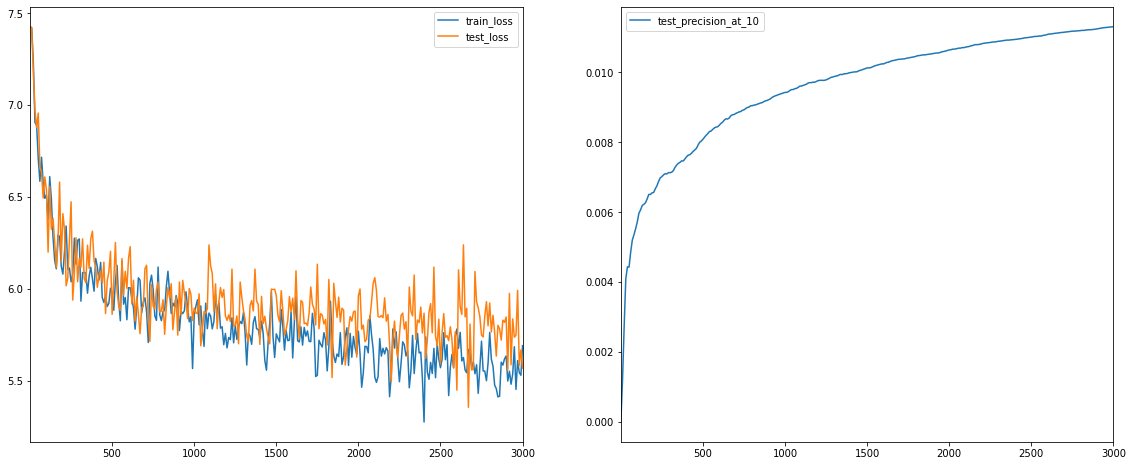

In [37]:
# Create feature embedding columns
def make_embedding_col(key, embedding_dim):
  categorical_col = tf.feature_column.categorical_column_with_vocabulary_list(
      key=key, vocabulary_list=list(set(movies[key].values)), num_oov_buckets=0)
  return tf.feature_column.embedding_column(
      categorical_column=categorical_col, dimension=embedding_dim,
      # default initializer: trancated normal with stddev=1/sqrt(dimension)
      combiner='mean')

with tf.Graph().as_default():
  softmax_model = build_softmax_model(
      rated_movies,
      embedding_cols=[
          make_embedding_col("movie_id", 35),
          make_embedding_col("genre", 3),
          make_embedding_col("year", 2),
      ],
      hidden_dims=[35])

softmax_model.train(
    learning_rate=8., num_iterations=3000, optimizer=tf.train.AdagradOptimizer)

### Inspect the embeddings

We can inspect the movie embeddings as we did for the previous models. Note that in this case, the movie embeddings are used at the same time as input embeddings (for the bag of words representation of the user history), and as softmax weights.

In [38]:
movie_neighbors(softmax_model, "Aladdin", DOT)
movie_neighbors(softmax_model, "Aladdin", COSINE)

Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


dot score  ...                                     genres
0       20.861  ...                  Animation-Children-Comedy
167     19.815  ...                                     Comedy
171     19.276  ...  Action-Adventure-Drama-Romance-Sci-Fi-War
94      19.183  ...          Animation-Children-Comedy-Musical
49      18.832  ...        Action-Adventure-Romance-Sci-Fi-War
120     18.634  ...                          Action-Sci-Fi-War

[6 rows x 3 columns]

Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


cosine score  ...                             genres
94          1.000  ...  Animation-Children-Comedy-Musical
70          0.888  ...         Animation-Children-Musical
417         0.816  ...         Animation-Children-Musical
172         0.812  ...    Action-Adventure-Comedy-Romance
27          0.808  ...              Action-Drama-Thriller
194         0.786  ...             Action-Sci-Fi-Thriller

[6 rows x 3 columns]

In [39]:
movie_embedding_norm([reg_model, softmax_model])

alt.HConcatChart(...)

In [40]:
tsne_movie_embeddings(softmax_model)

Running t-SNE...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1682 samples in 0.000s...
[t-SNE] Computed neighbors for 1682 samples in 0.115s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1682
[t-SNE] Computed conditional probabilities for sample 1682 / 1682
[t-SNE] Mean sigma: 0.189650
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.999306
[t-SNE] KL divergence after 400 iterations: 1.234171


alt.HConcatChart(...)